In [1]:
# Standard machine learning libraries
import pandas as pd                # dataframe library
import numpy as np                 # multi-dimentional arrays
import matplotlib.pyplot as plt    # figure plotting
%matplotlib inline

# Clustering libraries
from sklearn.preprocessing import PowerTransformer    # data normalization
from kmodes.kprototypes import KPrototypes            # clustering algorithm

# Plotting libraries
import plotnine as pn              # plotting

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Import
Data has been scraped from [Hiking Project](https://hikingproject.com) and stored within a csv file. This file is then imported into a pandas dataframe.

In [2]:
# Import data set from hosted data
df = pd.read_csv("https://raw.githubusercontent.com/KayleighEarly/MachineLearning/main/notebooks/data/raw_trail_data.csv")

# Import data set from local machine
# df = pd.read_csv("data/raw_trail_data.csv")

In [3]:
#Display basic data
df.head()

,url,Name,Difficulty,Distance,Type,High Elev,Low Elev,Elev Gained,Elev Lost,Avg Grade,Max Grade
0,https://www.hikingproject.com/trail/7000000/mo...,Mount Sanitas Loop,Intermediate/Difficult,3.2 Miles,Loop,"6,780' High","5,521' Low","1,281' High","1,280' Low",9°,23°
1,https://www.hikingproject.com/trail/7000100/lo...,Lower Big Bluestem Trail,Easy/Intermediate,2.0 Miles,Point to Point,"5,877' High","5,504' Low",397' High,25' Low,2°,9°
2,https://www.hikingproject.com/trail/7000500/mi...,Milner Pass - Fall River Pass Trail,Intermediate,3.5 Miles,Point to Point,"11,764' High","11,092' Low",13' High,685' Low,2°,4°
3,https://www.hikingproject.com/trail/7000600/bo...,Boulder Ridge Trail,Intermediate,1.2 Miles,Point to Point,"6,815' High","6,631' Low",217' High,221' Low,4°,10°
4,https://www.hikingproject.com/trail/7001600/mi...,Middle Fork Taylor Creek Trail,Intermediate,4.6 Miles,Out and Back,"5,921' High","5,482' Low",455' High,455' Low,2°,4°


## Data Features and Cleaning
The columns initially scraped from the site are as follows:

| Feature | Description |
| :------ | :---------: |
| url | the FQDN the data was scraped from |
| name | the reported name of the trail |
| difficulty | the avg reported difficult of the trails |
| dist | the length of the trail (miles) |
| type | the type of trail (loop, point to point, out and back, lollipop) |
| high_elev | the highest elevation reached in the trail (ft) |
| low_elev | the lowest elevation reached in the trail (ft) |
| elev_gain | the total elevation gained across the trail (ft) |
| elev_lost | the total elevation lost across the trail (ft) |
| grade_avg | the average grade of the trail (degrees) |
| grade_max | the maximum grade of the trail (degrees) |

Of these columns, the url and name are unique identifiers that aren't particularly useful for clustering and will be dropped (the url will be maintained until later in the application to allow for recommendations, but will not be part of the clustering data).

Next, the distance, high/low elevation, elevation gain/lost and average/maximum grade columns must be cleaned up to remove the units of measurement and convert the columns to numeric types.

After this rows that either had a null value for difficulty or a trail distance of 0 miles were removed from the dataset.

In [4]:
# Drop trail name
df.drop('Name', axis=1, inplace=True)

In [5]:
df = df.rename(columns={'Difficulty':'difficulty', 'Distance':'dist', 'Type':'type', 'High Elev':'high_elev', 
                   'Low Elev':'low_elev', 'Elev Gained':'elev_gain', 'Elev Lost':'elev_lost', 'Avg Grade': 
                   'grade_avg', 'Max Grade':'grade_max'})
df

,url,difficulty,dist,type,high_elev,low_elev,elev_gain,elev_lost,grade_avg,grade_max
0,https://www.hikingproject.com/trail/7000000/mo...,Intermediate/Difficult,3.2 Miles,Loop,"6,780' High","5,521' Low","1,281' High","1,280' Low",9°,23°
1,https://www.hikingproject.com/trail/7000100/lo...,Easy/Intermediate,2.0 Miles,Point to Point,"5,877' High","5,504' Low",397' High,25' Low,2°,9°
2,https://www.hikingproject.com/trail/7000500/mi...,Intermediate,3.5 Miles,Point to Point,"11,764' High","11,092' Low",13' High,685' Low,2°,4°
3,https://www.hikingproject.com/trail/7000600/bo...,Intermediate,1.2 Miles,Point to Point,"6,815' High","6,631' Low",217' High,221' Low,4°,10°
4,https://www.hikingproject.com/trail/7001600/mi...,Intermediate,4.6 Miles,Out and Back,"5,921' High","5,482' Low",455' High,455' Low,2°,4°
...,...,...,...,...,...,...,...,...,...,...
59458,https://www.hikingproject.com/trail/7101599/tw...,Intermediate,1.5 Miles,Point to Point,"1,720' High","1,404' Low",349' High,89' Low,3°,5°
59459,https://www.hikingproject.com/trail/7101799/sa...,Intermediate/Difficult,0.9 Miles,Point to Point,"6,391' High","5,263' Low","1,131' High",7' Low,13°,21°
59460,https://www.hikingproject.com/trail/7101899/sk...,Intermediate/Difficult,1.4 Miles,Point to Point,"5,504' High","5,007' Low",15' High,512' Low,4°,11°
59461,https://www.hikingproject.com/trail/7101999/be...,Easy,2.2 Miles,Out and Back,13' High,10' Low,14' High,13' Low,0°,1°


In [6]:
# Clean numerical values and convert column data types.
df['dist'] = df['dist'].str.rstrip(' Miles').str.replace(',', '').astype(float)
df['high_elev'] = df['high_elev'].str.rstrip("' High").str.replace(',', '').astype(float)
df['low_elev'] = df['low_elev'].str.rstrip("' Low").str.replace(',', '').astype(float)
df['elev_gain'] = df['elev_gain'].str.rstrip("' High").str.replace(',', '').astype(float)
df['elev_lost'] = df['elev_lost'].str.rstrip("' Low").str.replace(',', '').astype(float)
df['grade_avg'] = df['grade_avg'].str.rstrip("°").astype(int)
df['grade_max'] = df['grade_max'].str.rstrip("°").astype(int)

df

,url,difficulty,dist,type,high_elev,low_elev,elev_gain,elev_lost,grade_avg,grade_max
0,https://www.hikingproject.com/trail/7000000/mo...,Intermediate/Difficult,3.2,Loop,6780.0,5521.0,1281.0,1280.0,9,23
1,https://www.hikingproject.com/trail/7000100/lo...,Easy/Intermediate,2.0,Point to Point,5877.0,5504.0,397.0,25.0,2,9
2,https://www.hikingproject.com/trail/7000500/mi...,Intermediate,3.5,Point to Point,11764.0,11092.0,13.0,685.0,2,4
3,https://www.hikingproject.com/trail/7000600/bo...,Intermediate,1.2,Point to Point,6815.0,6631.0,217.0,221.0,4,10
4,https://www.hikingproject.com/trail/7001600/mi...,Intermediate,4.6,Out and Back,5921.0,5482.0,455.0,455.0,2,4
...,...,...,...,...,...,...,...,...,...,...
59458,https://www.hikingproject.com/trail/7101599/tw...,Intermediate,1.5,Point to Point,1720.0,1404.0,349.0,89.0,3,5
59459,https://www.hikingproject.com/trail/7101799/sa...,Intermediate/Difficult,0.9,Point to Point,6391.0,5263.0,1131.0,7.0,13,21
59460,https://www.hikingproject.com/trail/7101899/sk...,Intermediate/Difficult,1.4,Point to Point,5504.0,5007.0,15.0,512.0,4,11
59461,https://www.hikingproject.com/trail/7101999/be...,Easy,2.2,Out and Back,13.0,10.0,14.0,13.0,0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59463 entries, 0 to 59462
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   url         59463 non-null  object 
 1   difficulty  59435 non-null  object 
 2   dist        59463 non-null  float64
 3   type        59463 non-null  object 
 4   high_elev   59463 non-null  float64
 5   low_elev    59463 non-null  float64
 6   elev_gain   59463 non-null  float64
 7   elev_lost   59463 non-null  float64
 8   grade_avg   59463 non-null  int32  
 9   grade_max   59463 non-null  int32  
dtypes: float64(5), int32(2), object(3)
memory usage: 4.1+ MB


In [8]:
# Drop rows with empty values
df.dropna(subset = ["difficulty"], inplace=True)

In [9]:
# Drop rows with a trail distance of 0 miles
cols = ['dist']
df[cols] = df[df[cols] > 0][cols]
df.dropna(inplace=True)

At this point, we can check to see that there are no null values remaining in the dataset.

In [10]:
df.describe()

,dist,high_elev,low_elev,elev_gain,elev_lost,grade_avg,grade_max
count,59336.000000,59336.000000,59336.000000,59336.000000,59336.000000,59336.000000,59336.000000
mean,3.861823,3342.862714,2759.975849,664.133511,500.265471,3.356596,10.555042
std,23.331053,3261.242330,2866.642371,3558.833592,3520.405074,2.666761,8.021020
min,0.100000,0.000000,-1213.000000,0.000000,0.000000,0.000000,0.000000
25%,0.800000,782.750000,595.000000,47.000000,27.000000,1.000000,5.000000
50%,1.700000,1850.000000,1408.000000,187.000000,116.000000,3.000000,9.000000
75%,3.800000,5559.000000,4681.250000,677.000000,405.000000,5.000000,15.000000
max,3111.000000,22607.000000,19628.000000,450853.000000,451001.000000,32.000000,75.000000


Since clustering models don't perform well in the presence of outliers, we'll use standard deviations to determine any trails that lie outside of 4 standard deviations for each of the numerical columns. These outliers tend to be national trails that are captured via shorter trails already (i.e. AT, PCT, etc). Since the lower values are all below zero, there aren't any outliers on the short end. Therefore we'll only remove values on the large side.

In [11]:
# Remove outlier data for dist (anything outside of 4 standard deviations);
cols = ['dist','high_elev','low_elev','elev_gain','elev_lost','grade_avg','grade_max']

cut_off = df[cols].std() * 4
lower = df[cols].mean() - cut_off
upper = df[cols].mean() + cut_off

print(upper,'\n',lower)

df[cols] = df[df[cols] < upper][cols]
df.dropna(inplace=True)

df.describe()

dist            97.186035
high_elev    16387.832036
low_elev     14226.545335
elev_gain    14899.467880
elev_lost    14581.885769
grade_avg       14.023642
grade_max       42.639124
dtype: float64 
 dist           -89.462390
high_elev    -9702.106607
low_elev     -8706.593637
elev_gain   -13571.200858
elev_lost   -13581.354826
grade_avg       -7.310450
grade_max      -21.529039
dtype: float64


,dist,high_elev,low_elev,elev_gain,elev_lost,grade_avg,grade_max
count,58752.000000,58752.000000,58752.000000,58752.000000,58752.000000,58752.000000,58752.000000
mean,3.353990,3309.407969,2743.832533,585.092065,428.550977,3.274663,10.301249
std,5.585284,3230.712988,2849.108375,1009.143105,892.105767,2.463931,7.538543
min,0.100000,0.000000,-1213.000000,0.000000,0.000000,0.000000,0.000000
25%,0.800000,776.000000,593.000000,46.000000,28.000000,1.000000,5.000000
50%,1.700000,1818.000000,1396.000000,183.000000,115.000000,3.000000,9.000000
75%,3.700000,5518.000000,4663.000000,656.000000,400.000000,5.000000,14.000000
max,96.800000,16117.000000,13943.000000,14415.000000,14415.000000,14.000000,42.000000


# Data Preprocessing
Next we move on to preprocessing the data for clustering. First we make a copy of the data and drop the url from it. Once we have cluster labels made, we will apply it back to the original dataframe.

In [12]:
# Make copy of data for processing
working_df = df.copy()

# drop url from working data
working_df.drop(['url'], axis=1, inplace=True)
working_df

,difficulty,dist,type,high_elev,low_elev,elev_gain,elev_lost,grade_avg,grade_max
0,Intermediate/Difficult,3.2,Loop,6780.0,5521.0,1281.0,1280.0,9.0,23.0
1,Easy/Intermediate,2.0,Point to Point,5877.0,5504.0,397.0,25.0,2.0,9.0
2,Intermediate,3.5,Point to Point,11764.0,11092.0,13.0,685.0,2.0,4.0
3,Intermediate,1.2,Point to Point,6815.0,6631.0,217.0,221.0,4.0,10.0
4,Intermediate,4.6,Out and Back,5921.0,5482.0,455.0,455.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...
59458,Intermediate,1.5,Point to Point,1720.0,1404.0,349.0,89.0,3.0,5.0
59459,Intermediate/Difficult,0.9,Point to Point,6391.0,5263.0,1131.0,7.0,13.0,21.0
59460,Intermediate/Difficult,1.4,Point to Point,5504.0,5007.0,15.0,512.0,4.0,11.0
59461,Easy,2.2,Out and Back,13.0,10.0,14.0,13.0,0.0,1.0


### Utilize the Elbow Method to determine optimal number of clusters (k)
First we set some variables and convert the dataframe to a matrix

In [13]:
# Use Elbow Method to determine optimal K
categoricalCol = [0,2]
costs = []
n_clusters = []
clusters_assigned = []

# Data Standardization
for c in working_df.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    working_df[c] = pt.fit_transform(np.array(working_df[c]).reshape(-1,1))

# Convert dataframe to matrix
dfMatrix = working_df.to_numpy()
dfMatrix

array([['Intermediate/Difficult', 0.6267510240219285, 'Loop', ...,
        1.374246309590193, 1.8432325513577723, 1.475011834153777],
       ['Easy/Intermediate', 0.15114653827069843, 'Point to Point', ...,
        -0.69051764955405, -0.36957483832503335, 0.06109118494897926],
       ['Intermediate', 0.7134564839051809, 'Point to Point', ...,
        0.9898855917465199, -0.36957483832503335, -0.8235220096604766],
       ...,
       ['Intermediate/Difficult', -0.21875131715812715, 'Point to Point',
        ..., 0.8186602999003689, 0.5046663360552482, 0.32585379902075323],
       ['Easy', 0.249610758681805, 'Out and Back', ...,
        -0.9537035951227891, -1.9727412157965962, -1.7441778270109543],
       ['Easy/Intermediate', -0.7709769088475268, 'Point to Point', ...,
        -0.009237384801785927, 0.1117626670096853, -0.24392103750369093]],
      dtype=object)

Attempt clusters from 1 to 20.

In [33]:
# NOTE: This takes a long time.
for i in range(1, 20):
    try:
        kproto = KPrototypes(n_jobs = -1, n_clusters= i, init='Huang', verbose=2)
        clusters = kproto.fit_predict(dfMatrix, categorical=categoricalCol)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
        print('Cluster initiation: {}'.format(i))        
    except:
        print(f"Can't cluster with {i} clusters")

Best run was number 1
Cluster initiation: 1
Best run was number 2
Cluster initiation: 2
Best run was number 9
Cluster initiation: 3
Best run was number 10
Cluster initiation: 4
Best run was number 9
Cluster initiation: 5
Best run was number 3
Cluster initiation: 6
Best run was number 8
Cluster initiation: 7
Best run was number 9
Cluster initiation: 8
Best run was number 3
Cluster initiation: 9
Best run was number 6
Cluster initiation: 10
Best run was number 10
Cluster initiation: 11
Best run was number 2
Cluster initiation: 12
Best run was number 8
Cluster initiation: 13
Best run was number 5
Cluster initiation: 14
Best run was number 7
Cluster initiation: 15
Best run was number 1
Cluster initiation: 16
Best run was number 9
Cluster initiation: 17
Best run was number 5
Cluster initiation: 18
Best run was number 3
Cluster initiation: 19


Convert the results back to a dataframe and plot them.

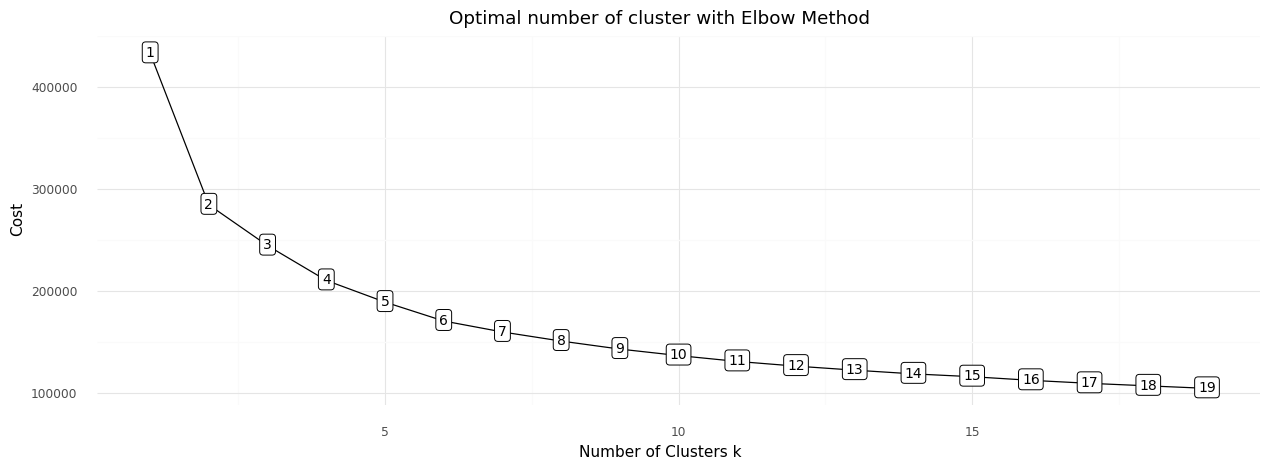

<ggplot: (133464956977)>

In [37]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 20), 'Cost':costs})

pn.options.figure_size = (15, 4.8)
(
    pn.ggplot(data = df_cost)+
    pn.geom_line(pn.aes(x = 'Cluster',
                  y = 'Cost'))+
    pn.geom_point(pn.aes(x = 'Cluster',
                   y = 'Cost'))+
    pn.geom_label(pn.aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    pn.labs(title = 'Optimal number of cluster with Elbow Method')+
    pn.xlab('Number of Clusters k')+
    pn.ylab('Cost')+
    pn.theme_minimal()
)       

The elbow method has a fairly gradual curve, making it difficult to tell where the optimal number of clusters is, however, it appears to more or less level out around 12 clusters.
# Data Clustering
We are using a K-Protoype algorithm for clustering. This is due to K-Means being optimized for all numeric data. K-Prototype tends to handle mixed data (numerical and categorical) better.
## Preprocessing for K-Prototype Clustering
There is minimal preprocessing needed for K-Prototype clustering, assuming an already cleaned dataset. 

In [38]:
df_kprot = working_df.copy()
categoricalCol = [0,2]

# Preprocessing
for c in df_kprot.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    df_kprot[c] = pt.fit_transform(np.array(df_kprot[c]).reshape(-1,1))
    
# Convert dataframe to matrix
dfMatrix = working_df.to_numpy()
dfMatrix

array([['Intermediate/Difficult', 0.6267510240219285, 'Loop', ...,
        1.374246309590193, 1.8432325513577723, 1.475011834153777],
       ['Easy/Intermediate', 0.15114653827069843, 'Point to Point', ...,
        -0.69051764955405, -0.36957483832503335, 0.06109118494897926],
       ['Intermediate', 0.7134564839051809, 'Point to Point', ...,
        0.9898855917465199, -0.36957483832503335, -0.8235220096604766],
       ...,
       ['Intermediate/Difficult', -0.21875131715812715, 'Point to Point',
        ..., 0.8186602999003689, 0.5046663360552482, 0.32585379902075323],
       ['Easy', 0.249610758681805, 'Out and Back', ...,
        -0.9537035951227891, -1.9727412157965962, -1.7441778270109543],
       ['Easy/Intermediate', -0.7709769088475268, 'Point to Point', ...,
        -0.009237384801785927, 0.1117626670096853, -0.24392103750369093]],
      dtype=object)

After preprocessing, we run the K-Prototype algorithm on the data with 12 clusters.

In [39]:
# Actual clustering
model = KPrototypes(n_jobs = -1, n_clusters= 12, init='Huang')
clusters = model.fit_predict(dfMatrix, categorical=categoricalCol)

We can then check the distribution across the clusters, as well as some of the basic cluster details.

In [40]:
# Prints the count of each cluster group
pd.Series(clusters).value_counts()

0     7198
11    7153
1     6114
7     5779
6     5725
4     4815
9     4302
8     4209
3     4017
2     3713
5     3147
10    2580
dtype: int64

In [41]:
# Check the iteration of the clusters created
model.n_iter_

101

In [42]:
# Check the cost of the clusters created
model.cost_

126786.83450857596

In [43]:
# Check the location of the cluster centroids.
model.cluster_centroids_

array([['-1.0969235720260193', '-0.766356978053501',
        '-0.6822268894212836', '-0.798529873849685',
        '-0.4412744341542501', '-0.14750457514063575',
        '-0.4013886132732756', 'Intermediate', 'Point to Point'],
       ['-0.9969041741369224', '-1.194386764798367',
        '-0.833126602161756', '-1.260057871734516',
        '-1.0294824473259645', '-1.4267628034553717',
        '-1.5645246700417759', 'Easy', 'Point to Point'],
       ['0.07254568596848576', '1.2081357017395338',
        '1.2114973674579472', '1.0548026196519835',
        '-1.1520819461712255', '1.2974179535711077', '0.985803875742831',
        'Difficult', 'Point to Point'],
       ['1.1177883293873028', '0.40769345288992415',
        '-0.20983847756047258', '1.3018327450153446',
        '1.229624217810597', '0.9946421791275346', '1.34182438332496',
        'Difficult', 'Point to Point'],
       ['1.1490166854828985', '-0.4061815019735225',
        '-0.6190077991261116', '0.6600124702490455',
        '0.86

### Labeling the data
Once satisfied with the clusters, we then apply the cluster labels to each row of data initially passed in.

In [44]:
# Add the cluster to the dataframe
df['Cluster Labels'] = model.labels_

df

,url,difficulty,dist,type,high_elev,low_elev,elev_gain,elev_lost,grade_avg,grade_max,Cluster Labels
0,https://www.hikingproject.com/trail/7000000/mo...,Intermediate/Difficult,3.2,Loop,6780.0,5521.0,1281.0,1280.0,9.0,23.0,9
1,https://www.hikingproject.com/trail/7000100/lo...,Easy/Intermediate,2.0,Point to Point,5877.0,5504.0,397.0,25.0,2.0,9.0,6
2,https://www.hikingproject.com/trail/7000500/mi...,Intermediate,3.5,Point to Point,11764.0,11092.0,13.0,685.0,2.0,4.0,6
3,https://www.hikingproject.com/trail/7000600/bo...,Intermediate,1.2,Point to Point,6815.0,6631.0,217.0,221.0,4.0,10.0,6
4,https://www.hikingproject.com/trail/7001600/mi...,Intermediate,4.6,Out and Back,5921.0,5482.0,455.0,455.0,2.0,4.0,6
...,...,...,...,...,...,...,...,...,...,...,...
59458,https://www.hikingproject.com/trail/7101599/tw...,Intermediate,1.5,Point to Point,1720.0,1404.0,349.0,89.0,3.0,5.0,11
59459,https://www.hikingproject.com/trail/7101799/sa...,Intermediate/Difficult,0.9,Point to Point,6391.0,5263.0,1131.0,7.0,13.0,21.0,2
59460,https://www.hikingproject.com/trail/7101899/sk...,Intermediate/Difficult,1.4,Point to Point,5504.0,5007.0,15.0,512.0,4.0,11.0,10
59461,https://www.hikingproject.com/trail/7101999/be...,Easy,2.2,Out and Back,13.0,10.0,14.0,13.0,0.0,1.0,1


### Exporting Labeled Data
Lastly, we export the labeled data to a csv file to be used for classification later.

In [50]:
df.to_csv('data\labeled_trail_data.csv', index=False)